# BÁO CÁO ĐỒ ÁN MÔN "KHOA HỌC DỮ LIỆU & ỨNG DỤNG"
### GVHD: TRẦN TRUNG KIÊN
### THỰC HIỆN: Nhóm 12
### DANH SÁCH THÀNH VIÊN
  1. 1712667 - Lê Hữu Phúc
  2. 18120167 - Nguyễn Viết Dũng
  3. 18120579 - Đặng Minh Thọ
  4. 18120584 - Phạm Đình Thục
  
#### Link thùng chứa Github của nhóm: https://github.com/pdthuc/Project-Applied_Data_Science

# 1. MÔ TẢ BÀI TOÁN




## 1.1 GIỚI THIỆU ĐỀ TÀI

- **Tên cuộc thi:** Recruit Restaurant Visitor Forecasting
- **Mô tả bài toán:** 
    - Bài toán dự đoán **số lượng khách hàng** sẽ đến **01 nhà hàng** vào **01 ngày bất kỳ** trong tương lai. Việc dự đoán sẽ dựa vào các thông tin về vị trí (kinh độ, vĩ độ) của nhà hàng, các ngày lễ trong năm, thông tin dự báo thời tiết ngày hôm đó và dữ liệu đặt chỗ thông qua trang web đặt chỗ của nhà hàng và dữ liệu khách đã đến trong cơ sở dữ liệu của nhà hàng.
    - **Input**: là mã của nhà hàng (`air_store_id`) và ngày cần dự đoán (`visit_date`).
    - **Output**: Số lượng khách (`visitors`) sẽ đến nhà hàng.
- **Prize:** $ 25000
- **Participants:** 2148 teams
- **Link Kaggle:** https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting


## 1.2 GIỚI THIỆU SOLUTION

- **Solution:**
  - Trong đồ án này, nhóm đã tìm hiểu và cài đặt lại phương pháp nằm trong top 10 Private Leaderboard.
  - Xếp hạng solution: Top 8 Private Leaderboard với `score` = 0.50775
  - Tác giả: MaxHalford 
  - Link Solution: https://github.com/MaxHalford/kaggle-recruit-restaurant
  - Lí do chọn solution này: Vì solution có code sẵn và được mô tả rõ ràng bởi tác giả. Hướng giải quyết bài toán phù hợp với trình độ các thành viên trong nhóm.


## 1.3 SƠ LƯỢC VỀ DỮ LIỆU


Dữ liệu đến từ hai trang web riêng biệt: 
  - Hot Pepper Gourmet (hpg): tại đây người dùng có thể tìm kiếm nhà hàng và đặt chỗ trực tuyến 
  - AirREGI / Restaurant Board (air): hệ thống kiểm soát đặt chỗ và tính tiền
  
Được thu thập từ năm 2016 đến tháng 4 năm 2017 
- AIR: 829 restaurants 
- HPG: 4690 restaurants
Dữ liệu thu thập bao gồm các thông tin liên quan đến nhà hàng (id, latitude, longitude, ...), các thông tin về số lượng khách đặt chỗ tại các nhà hàng và các thông tin liên quan đến thời tiết, ngày lễ.

Ngoài việc dùng dữ liệu từ hai trang web trên, tác giả còn sử dụng thêm dữ liệu về thời tiết tại các trạm ở Nhật Bản được thu thập bởi Hunter McGushion giúp ích cho cuộc thi của Recruit Restaurant Visitor Forecasting. 

Tập dữ liệu: [Weather Data for Recruit Restaurant Competition](https://www.kaggle.com/huntermcgushion/rrv-weather-data) được thu thập từ ngày 1-1-2016 đến 31-5-2017 chứa thông tin về 1663 trạm thời tiết ở Nhật Bản.



## 1.4 IMPORT CÁC THƯ VIỆN CẦN THIẾT

In [4]:
# Mount Drive
from google.colab import drive
import os
drive.mount('/content/drive')

# Kiểm tra có mount được đến thư mục chứa data hay không?
os.chdir("/content/drive/My Drive/Colab Notebooks/KHDL")
!ls


import pandas as pd
import numpy as np
import lightgbm as lgbm
from sklearn import metrics
from sklearn import model_selection
import glob


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data  Report.ipynb  submissionslgbm_0.54548_0.00174.csv


# 2. GIẢI QUYẾT BÀI TOÁN 

Về cơ bản, nhóm tìm hiểu và code lại dựa trên mô tả và code mà tác giả cung cấp. Với một số bước mà tác giả không giải thích rõ ràng (nhóm  sẽ nói rõ khi đi vào các bước ở bên dưới), nhóm cũng phân tích và thí nghiệm thêm để thấy rõ hơn là tại sao lại cần có bước này. Trong quá trình code lại thì nhóm cũng có điều chỉnh một số chỗ để code ngắn gọn và rõ ràng hơn (chỗ nào code lại hoàn toàn theo tác giả và chỗ nào code lại có điều chỉnh thì nhóm đều có comment rõ ràng trong phần code ở bên dưới).

## 2.1 KHÁM PHÁ DỮ LIỆU NHÀ HÀNG





---
### 2.1.1 File `air_visit_data.csv`




- **Input:** Trong file `air_visit_data.csv` liên quan về dữ liệu khách hàng theo ngày của từng nhà hàng. Trong file biểu diễn dữ liệu theo ngày (những ngày không có khách sẽ không được thu thập).
- **Phương pháp:** Những ngày không có khách thì ta sẽ gán giá trị cho lượt truy cập sẽ là 0. Gán cờ `was_nil` cho những ngày đó.
- **Output**: Dữ liệu khách của từng nhà hàng được sắp xếp liên tục theo từng ngày (kể cả những ngày không được thu thập).
- **Mục đích**: Có ích cho việc tính toán luân phiên dựa vào thời gian.


In [ ]:
air_visit = pd.read_csv('data/air_visit_data.csv')

# add NaN values
air_visit.index = pd.to_datetime(air_visit['visit_date'])
air_visit = air_visit.groupby('air_store_id').apply(lambda g: g['visitors'].resample('1d').sum()).reset_index()
air_visit.replace(0, np.nan, inplace=True)
air_visit.head()

,air_store_id,visit_date,visitors
0,air_00a91d42b08b08d9,2016-07-01,35.0
1,air_00a91d42b08b08d9,2016-07-02,9.0
2,air_00a91d42b08b08d9,2016-07-03,NaN
3,air_00a91d42b08b08d9,2016-07-04,20.0
4,air_00a91d42b08b08d9,2016-07-05,25.0


In [ ]:
air_visit['visit_date'] = air_visit['visit_date'].dt.strftime('%Y-%m-%d')
air_visit['was_nil'] = air_visit['visitors'].isnull()
air_visit['visitors'].fillna(0, inplace=True)

air_visit.head()

,air_store_id,visit_date,visitors,was_nil
0,air_00a91d42b08b08d9,2016-07-01,35.0,False
1,air_00a91d42b08b08d9,2016-07-02,9.0,False
2,air_00a91d42b08b08d9,2016-07-03,0.0,True
3,air_00a91d42b08b08d9,2016-07-04,20.0,False
4,air_00a91d42b08b08d9,2016-07-05,25.0,False


---
### 2.1.2 File `date_info.csv`




- **Input:** Trong file `date_info.csv` liên quan đến dữ liệu các ngày lễ, bao gồm: Thứ, ngày, tháng, năm và cờ `holiday_flg`.
- **Phương pháp:** Ta thêm hai biến flag cho biết ngày hôm trước (`prev_day_is_holiday`) và ngày hôm sau (`next_day_is_holiday`) của ngày đang xét có phải là ngày lễ hay không?
- **Output**: Dữ liệu ngày lễ sẽ chứa thêm các đặc trưng: `next_day_is_holiday`,`prev_day_is_holiday`
- **Mục đích:** Điều này giúp ta biết được ngày đang xét là ngày lễ đơn hay nằm trong kỳ nghỉ lễ dài ngày.


In [ ]:
date_info = pd.read_csv('data/date_info.csv')

date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [ ]:
# add flag for prev_day and next_day
date_info.rename(columns={'holiday_flg': 'is_holiday', 'calendar_date': 'visit_date'}, inplace=True)
date_info['prev_day_is_holiday'] = date_info['is_holiday'].shift().fillna(0)
date_info['next_day_is_holiday'] = date_info['is_holiday'].shift(-1).fillna(0)

date_info.head()

,visit_date,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday
0,2016-01-01,Friday,1,0.0,1.0
1,2016-01-02,Saturday,1,1.0,1.0
2,2016-01-03,Sunday,1,1.0,0.0
3,2016-01-04,Monday,0,1.0,0.0
4,2016-01-05,Tuesday,0,0.0,0.0


---
### 2.1.3 File `air_store_info.csv`


- **Input:** Trong file `air_store_info.csv` liên quan đến dữ liệu thông tin về nhà hàng. Tuy nhiên trong dữ liệu đến từ cuộc thi còn thiếu nhiều đặc trưng.
- **Phương pháp:** Sử dụng phiên bản xử lý trước thay vì phiên bản hiện tại của cuộc thi (vì nó chứa dữ liệu quan trọng của các trạm quan sát thời tiết). Ta có thể truy cập dữ liệu này ở [đây](https://www.kaggle.com/huntermcgushion/rrv-weather-data). 
- **Output:** Dữ liệu sẽ chứa thêm các đặc trưng như: `station_id` (id của các trạm gần nhà hàng nhất), `station_latitude` (vĩ độ của trạm), `station_longitude` (kinh độ của trạm),…
- **Mục đích:** Tăng thêm các thuộc tính nhằm tăng độ chính xác cho quá trình huấn luyện.




In [ ]:
# recent data

air_store_info = pd.read_csv('data/air_store_info.csv')
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [ ]:
# extened data

air_store_info = pd.read_csv('data/air_store_info_with_nearest_active_station.csv')
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,"""34.6951242""","""135.1978525""",hyogo__kobe-kana__koube,34.696667,135.211667,1.277232,1.274882
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,"""35.6580681""","""139.7515992""",tokyo__tokyo-kana__tonokyo,35.691667,139.750000,3.730672,3.739835


---
### 2.1.4 File `sample_submission.csv`


- **Input:** Trong file `sample_submission.csv` chứa thông tin tập **test**. Vì id trong sample là chuỗi gồm id + visit_date.
- **Phương pháp:** Ta cần tách ra `id` riêng và `visit_date` riêng. Tạo thêm 2 cột `is_test` và `test_number`.
- **Output:** Dữ liệu sẽ sample sẽ tách các đặc trưng `id` và `visit_date` và thêm các đặc trưng mới: `is_test` và `test_number`.
- **Mục đích:** Việc tạo cột `test_number` nhằm để các kết quả dự đoán (submission) được sắp xếp theo đúng thứ tự và `is_test` để tránh nhầm lẫn dữ liệu train.




In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission['air_store_id'] = submission['id'].str.slice(0, 20)
submission['visit_date'] = submission['id'].str.slice(21)
submission['is_test'] = True
submission['visitors'] = np.nan
submission['test_number'] = range(len(submission))

submission.head()

,id,visitors,air_store_id,visit_date,is_test,test_number
0,air_00a91d42b08b08d9_2017-04-23,NaN,air_00a91d42b08b08d9,2017-04-23,True,0
1,air_00a91d42b08b08d9_2017-04-24,NaN,air_00a91d42b08b08d9,2017-04-24,True,1
2,air_00a91d42b08b08d9_2017-04-25,NaN,air_00a91d42b08b08d9,2017-04-25,True,2
3,air_00a91d42b08b08d9_2017-04-26,NaN,air_00a91d42b08b08d9,2017-04-26,True,3
4,air_00a91d42b08b08d9_2017-04-27,NaN,air_00a91d42b08b08d9,2017-04-27,True,4


In [ ]:
# delete colum: `id`
data = pd.concat((air_visit, submission.drop('id', axis='columns')))

data.head()

,air_store_id,visit_date,visitors,was_nil,is_test,test_number
0,air_00a91d42b08b08d9,2016-07-01,35.0,False,NaN,NaN
1,air_00a91d42b08b08d9,2016-07-02,9.0,False,NaN,NaN
2,air_00a91d42b08b08d9,2016-07-03,0.0,True,NaN,NaN
3,air_00a91d42b08b08d9,2016-07-04,20.0,False,NaN,NaN
4,air_00a91d42b08b08d9,2016-07-05,25.0,False,NaN,NaN


## 2.2 KHÁM PHÁ DỮ LIỆU THỜI TIẾT

---
### 2.2.1 Merge dataset


- **Input:** 2 bộ dữ liệu train và sample_submission
- **Phương pháp:** Merge 2 tập lại với nhau.
- **Output:** Tập dữ liệu data gồm thông tin từ 2 tập đầu vào.
- **Mục đích:** Hợp nhất tập hợp train và test là một ý tưởng hay để trích xuất các tính năng trong một lần.



In [ ]:
data['is_test'].fillna(False, inplace=True)
data = pd.merge(left=data, right=date_info, on='visit_date', how='left')
data = pd.merge(left=data, right=air_store_info, on='air_store_id', how='left')
data['visitors'] = data['visitors'].astype(float)

data.head()

,air_store_id,visit_date,visitors,was_nil,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle
0,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,NaN,Friday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
1,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,NaN,Saturday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
2,air_00a91d42b08b08d9,2016-07-03,0.0,True,False,NaN,Sunday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
3,air_00a91d42b08b08d9,2016-07-04,20.0,False,False,NaN,Monday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
4,air_00a91d42b08b08d9,2016-07-05,25.0,False,False,NaN,Tuesday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906


--- 
### 2.2.2 Dữ liệu thời tiết

- **Input:** `1663` file Dữ liệu về thời tiết mỗi file ứng với 1 trạm thời tiết.
- **Phương pháp:**
  - Nhập dữ liệu thời tiết ứng với mỗi file vào bảng `weather`. 
- **Output:** Dữ liệu trong `weather` chứa thông tin thời tiết của các trạm thời tiết.
- **Mục đích:** Trong bảng này có nhiều dữ liệu không tồn tại `NaN` với nhiều lý do:    
  * 01 khu vực quanh năm nắng nóng sẽ không cần tới loại dữ liệu snowfall và tương tự.
  * 01 số trạm thời tiết nhỏ chỉ có 1 nhiệm vụ là đo lượng mưa và có những trạm lớn sẽ đo nhiều thông số thời tiết.
  * 01 số trạm ở khu vực vùng núi sẽ không thể đo đạc các chỉ số liên qua đến biển.






In [ ]:
weather_dfs = []

for path in glob.glob('data/1-1-16_5-31-17_Weather/*.csv'):
    weather_df = pd.read_csv(path)
    weather_df['station_id'] = path.split('\\')[-1].rstrip('.csv')
    weather_dfs.append(weather_df)


weather = pd.concat(weather_dfs, axis='rows')
weather.rename(columns={'calendar_date': 'visit_date'}, inplace=True)


In [ ]:
weather.head(5)

,visit_date,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,deepest_snowfall,total_snowfall,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover,station_id
0,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data/1-1-16_5-31-17_Weather/hokkaido_kamikawa_...
1,2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data/1-1-16_5-31-17_Weather/hokkaido_kamikawa_...
2,2016-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data/1-1-16_5-31-17_Weather/hokkaido_kamikawa_...
3,2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data/1-1-16_5-31-17_Weather/hokkaido_kamikawa_...
4,2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data/1-1-16_5-31-17_Weather/hokkaido_kamikawa_...


---
### 2.2.3 Trích chọn dữ liệu thời tiết

Ở bước này, tác giả không nói rõ việc tại sao lại trích chọn các giá trị. Nhóm đã đọc và trình bày lại theo cách hiểu của nhóm để giải thích tại sao lại chọn các giá trị đó.

- **Input:** Thông tin về các chỉ số liên quan đến thời tiết từ bảng `weather`.
Trích chọn các giá trị thực sự ảnh hưởng đến việc dự đoán số lượng khách hàng của một nhà hàng.
  - Vì là số lượng khách hàng được tính trong 1 ngày nên các giá trị về nhiệt độ cao nhất hay thấp nhất trong 1 ngày ảnh hưởng ít đến số lượng khách. Cái ta quan tâm là trong một ngày chứ không theo giờ. Nên nhiệt độ trung bình sẽ là lựa chọn hợp lý.
  - Đối với nhà hàng, thời gian mở cửa thường không thay đổi nên các chỉ số về mặt trời mọc hay lặn sẽ không ảnh hưởng đến các quyết định của nhà hàng.
  - Một số yếu tố khó có thể biết được trong tương lai thì sẽ không được chọn. Thay vào đó các yếu tố dễ dàng thu thập được sẽ ưu tiên chọn.
  - Các dữ liệu còn lại missing nhiều, nên không thể dùng được.
- **Phương pháp:** Sau khi đã cân nhắc và xem xét, ta quyết định chọn ra các giá trị quan trọng đến số lượng khách:
  - Lượng mưa trung bình trong 1 ngày.
  - Nhiệt độ trung bình trong 1 ngày.
  - (lượt bỏ các giá trị khác).
- **Output:** Dữ liệu thời tiết chỉ còn 3 đặc trưng: `visit_date`,  `avg_temperature`,	`precipitation`.
- **Mục đích:** Trích chọn nhằm chọn ra những giá trị thực sự cần thiết cho mô hình và làm giảm tải lượng lớn dữ liệu không cần thiết để tăng tốc cho mô hình huấn luyện.


In [ ]:
means = weather.groupby('visit_date')[['avg_temperature', 'precipitation']].mean().reset_index()
means.rename(columns={'avg_temperature': 'global_avg_temperature', 'precipitation': 'global_precipitation'}, inplace=True)
weather = pd.merge(left=weather, right=means, on='visit_date', how='left')
weather['avg_temperature'].fillna(weather['global_avg_temperature'], inplace=True)
weather['precipitation'].fillna(weather['global_precipitation'], inplace=True)

weather[['visit_date', 'avg_temperature', 'precipitation']].head()

,visit_date,avg_temperature,precipitation
0,2016-01-01,2.868353,0.564662
1,2016-01-02,5.279225,2.341998
2,2016-01-03,6.589978,1.750616
3,2016-01-04,5.857883,1.644946
4,2016-01-05,4.556850,3.193625


---
### 2.2.4 Kết quả thu được

Sau quá trình khám phá ta thu được bộ dữ liệu như sau:

In [ ]:
data['visit_date'] = pd.to_datetime(data['visit_date'])
data.index = data['visit_date']
# data.sort_values(['air_store_id', 'visit_date'], inplace=True)

data.head()

,air_store_id,visit_date,visitors,was_nil,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle
visit_date,,,,,,,,,,,,,,,,,,,,,
2016-07-01,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,NaN,Friday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
2016-07-02,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,NaN,Saturday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
2016-07-03,air_00a91d42b08b08d9,2016-07-03,0.0,True,False,NaN,Sunday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
2016-07-04,air_00a91d42b08b08d9,2016-07-04,20.0,False,False,NaN,Monday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906
2016-07-05,air_00a91d42b08b08d9,2016-07-05,25.0,False,False,NaN,Tuesday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906


## 2.3 TIỀN XỬ LÝ DỮ LIỆU


### 2.3.1 Xử lý outliers

Ở bước này, nhóm đã tìm hiểu và code lại dựa trên mô tả và code mà tác giả cung cấp. Ngoài ra, nhóm còn tìm hiểu thêm để giải thích cho việc lựa chọn của tác giả.

*   **Input:** Tập dữ liệu train
*   **Output:** Dữ liệu đã được lượt bỏ giá trị outliers và tạo thêm đặc trưng `log1p` của giá trị được loại bỏ outliers.
*   **Mục đích:** lượt bỏ các giá trị gây nhiễu cho quá trình huấn luyện.
*   **Phương pháp:**





Ta thực hiện lượt bỏ bớt các phần tử có giá trị lớn nhưng không thể hiện đúng phân bố của dữ liệu gây nhiễu cho quá trình huấn luyện (outlier).


*Ví dụ:* Số lượt truy cập vào dịp năm mới rõ ràng không đại diện cho các thời điểm còn lại trong năm.

Giả sử rằng lượt truy cập tuân theo phân phối chuẩn cho mỗi nhà hàng.

Ta chọn hệ số Z là 2.4 để có khoản tin cậy khoảng 97% và lượt bỏ khoảng 3% số lượng giá trị outlier. Bạn có thể tham khảo thêm tại [đây](https://www.mathsisfun.com/data/confidence-interval-calculator.html) và ở [đây](https://www.statisticshowto.com/probability-and-statistics/z-score/) để biết thêm về hệ số Z.


 <font size="5"> $$ x - \overline{x} = Z * s  $$  </font>

Trong đó: 
- $ \overline{x}: mean $
- $ Z: \text{hệ số score} $
- $ s:  \text{độ lệch chuẩn}$


|   | $$ Z $$ |
|---|---|
| 80% | 1.282|
| 85% | 1.440 | 
| 90% | 1.645   |
| 95% | 1.960  | 
| 99.5% | 2.576 |
| 99.9% | 3.291 |

Những dòng có giá trị outlier sẽ được thay thế bằng max của những giá trị trong khoảng tin cậy.

Tiếp theo ta tính **log1p** để transform lại dữ liệu, giúp dữ liệu phân bố tốt hơn, không bị lệch phải do các giá trị outlier chưa được lượt bỏ hết. Bạn có thể tham khảo tại [đây](https://gdcoder.com/when-why-to-use-log-transformation-in-regression/) để biết thêm về **log-transform**

In [ ]:
def find_outliers(series):
    return (series - series.mean()) > 2.4 * series.std()


def cap_values(series):
    outliers = find_outliers(series)
    max_val = series[~outliers].max()
    series[outliers] = max_val
    return series


stores = data.groupby('air_store_id')
data['is_outlier'] = stores.apply(lambda g: find_outliers(g['visitors'])).values
data['visitors_capped'] = stores.apply(lambda g: cap_values(g['visitors'])).values
data['visitors_capped_log1p'] = np.log1p(data['visitors_capped'])

data.head()

,air_store_id,visit_date,visitors,was_nil,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,is_outlier,visitors_capped,visitors_capped_log1p
visit_date,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,NaN,Friday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,35.0,3.583519
2016-07-02,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,NaN,Saturday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,9.0,2.302585
2016-07-03,air_00a91d42b08b08d9,2016-07-03,0.0,True,False,NaN,Sunday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,0.0,0.000000
2016-07-04,air_00a91d42b08b08d9,2016-07-04,20.0,False,False,NaN,Monday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,20.0,3.044522
2016-07-05,air_00a91d42b08b08d9,2016-07-05,25.0,False,False,NaN,Tuesday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,25.0,3.258097


### 2.3.2 Trích xuất thêm các đặc trưng.



*   **Input:** Dữ liệu về thứ và ngày.
*   **Output:** Dữ liệu được thêm các đặc trưng mới: `is_weekend`, `day_of_month`.
*   **Mục đích:** Tạo thêm một số đặc trưng giúp phát hiện tính chu kỳ của dữ liệu thời gian.

Các đặc trưng cần thêm:
 - Ngày cuối tuần(`is_weekend`)
 - Ngày trong tháng(`day_of_month`)

Những đặt trưng này có thể được coi là đại diện cho thời điểm
- Thường hay ăn chơi dịp cuối tuần.
- Mọi người được trả tiền trong tháng, giả sử họ được trả tiền hàng tháng.


In [ ]:
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
data['day_of_month'] = data['visit_date'].dt.day

### 2.3.3 Tính trọng số theo cấp số nhân cho số lượng khách hàng.



*   **Input:** Tập dữ liệu train, test, dữ liệu của các nhà hàng cần dự đoán số lượng khách trong quá khứ.
*   **Output:** Tập dữ liệu mới có thêm các đặc trưng là trọng số theo cấp số nhân của số lượng khách hàng trong ngày của nhà hàng.
*   **Mục đích:** Do dữ liệu liên quan đến chuỗi thời gian nên cần tính EWM để nắm bắt xu hướng của khách hàng nhằm tạo ra các đặc trưng cần thiết cho quá trình huấn luyện.
*   **Phương pháp:**
  Trọng số theo cấp số nhân - Exponentially weighted means (EWM) 

   Ta tính [EWM](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html) để tăng trọng số cho số lượng khách hàng của ngày hiện tại dựa trên những ngày trước đó, điều này nhằm mục đích nằm bắt được xu hướng của khách hàng.

   Để tính EWM cần biết tham số **alpha**. Ở đây ta dùng thư viện [optimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) để tìm **alpha** tốt nhất cho giá trị EWM. Ta dùng **mean square error** để làm giá trị trả về cho hàm cần tối ưu. Ở đây ta cần tìm `min` của hàm f.





In [ ]:
from scipy import optimize


def calc_shifted_ewm(series, alpha, adjust=True):
    return series.shift().ewm(alpha=alpha, adjust=adjust).mean()


def find_best_signal(series, adjust=False, eps=10e-5):
    
    def f(alpha):
        shifted_ewm = calc_shifted_ewm(series=series, alpha=min(max(alpha, 0), 1), adjust=adjust)
        corr = np.mean(np.power(series - shifted_ewm, 2))
        return corr
     
    res = optimize.differential_evolution(func=f, bounds=[(0 + eps, 1 - eps)])
    
    return calc_shifted_ewm(series=series, alpha=res['x'][0], adjust=adjust)


roll = data.groupby(['air_store_id', 'day_of_week']).apply(lambda g: find_best_signal(g['visitors_capped']))
data['optimized_ewm_by_air_store_id_&_day_of_week'] = roll.sort_index(level=['air_store_id', 'visit_date']).values

roll = data.groupby(['air_store_id', 'is_weekend']).apply(lambda g: find_best_signal(g['visitors_capped']))
data['optimized_ewm_by_air_store_id_&_is_weekend'] = roll.sort_index(level=['air_store_id', 'visit_date']).values

roll = data.groupby(['air_store_id', 'day_of_week']).apply(lambda g: find_best_signal(g['visitors_capped_log1p']))
data['optimized_ewm_log1p_by_air_store_id_&_day_of_week'] = roll.sort_index(level=['air_store_id', 'visit_date']).values

roll = data.groupby(['air_store_id', 'is_weekend']).apply(lambda g: find_best_signal(g['visitors_capped_log1p']))
data['optimized_ewm_log1p_by_air_store_id_&_is_weekend'] = roll.sort_index(level=['air_store_id', 'visit_date']).values

data.head()

,air_store_id,visit_date,visitors,was_nil,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,is_outlier,visitors_capped,visitors_capped_log1p,is_weekend,day_of_month,optimized_ewm_by_air_store_id_&_day_of_week,optimized_ewm_by_air_store_id_&_is_weekend,optimized_ewm_log1p_by_air_store_id_&_day_of_week,optimized_ewm_log1p_by_air_store_id_&_is_weekend
visit_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,NaN,Friday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,35.0,3.583519,0,1,NaN,NaN,NaN,NaN
2016-07-02,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,NaN,Saturday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,9.0,2.302585,1,2,NaN,NaN,NaN,NaN
2016-07-03,air_00a91d42b08b08d9,2016-07-03,0.0,True,False,NaN,Sunday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,0.0,0.000000,1,3,NaN,9.00000,NaN,2.302585
2016-07-04,air_00a91d42b08b08d9,2016-07-04,20.0,False,False,NaN,Monday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,20.0,3.044522,0,4,NaN,35.00000,NaN,3.583519
2016-07-05,air_00a91d42b08b08d9,2016-07-05,25.0,False,False,NaN,Tuesday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,25.0,3.258097,0,5,NaN,33.04746,NaN,3.454852


### 2.3.4 Tính toán các đặc trưng.

Ở bước này, nhóm đã tìm hiểu và code lại dựa trên mô tả và code mà tác giả cung cấp. Tuy nhiên, tác giả không giải thích rõ phần này. Nhóm đã thử nghiệm việc lượt bỏ các đặc trưng này đi để đánh giá. Kết quả cho ra thấp hơn ban đầu.

*   **Input:** Tập dữ liệu được xử lý ở bước 2.3.3.
*   **Output:** Tập dữ liệu được thêm một số đặc trưng như mean, median,...
*   **Mục đích:** Trích xuất thêm một số đặc trưng mới giúp ích cho quá trình huấn luyện.
*   **Phương pháp:** Ta gom nhóm dữ liệu, chọn các giá trị alpha cố định để tính EWM sau đó tính toán và tạo thêm các đặc trưng mới cho dữ liệu train.

Tính các đặc trưng với tham số **alpha** cố định như:
- Trung bình (mean)
- Trung vị (median)
- Độ lệch chuẩn (standard deviation)
- Số lượng giá trị
- Tối thiểu (min)
- Tối đa (max)
- Giá trị EWM.



In [ ]:
def extract_precedent_statistics(df, on, group_by):

    df.index.name = None
    
    df.sort_values(group_by + ['visit_date'], inplace=True)
    
    groups = df.groupby(group_by, sort=False)
    
    stats = {
        'mean': [],
        'median': [],
        'std': [],
        'count': [],
        'max': [],
        'min': []
    }
    
    exp_alphas = [0.1, 0.25, 0.3, 0.5, 0.75]
    stats.update({'exp_{}_mean'.format(alpha): [] for alpha in exp_alphas})
    
    for _, group in groups:
        
        shift = group[on].shift()
        roll = shift.rolling(window=len(group), min_periods=1)
        
        stats['mean'].extend(roll.mean())
        stats['median'].extend(roll.median())
        stats['std'].extend(roll.std())
        stats['count'].extend(roll.count())
        stats['max'].extend(roll.max())
        stats['min'].extend(roll.min())
        
        for alpha in exp_alphas:
            exp = shift.ewm(alpha=alpha, adjust=False)
            stats['exp_{}_mean'.format(alpha)].extend(exp.mean())
    
    suffix = '_&_'.join(group_by)
    
    for stat_name, values in stats.items():
        df['{}_{}_by_{}'.format(on, stat_name, suffix)] = values


extract_precedent_statistics(
    df=data,
    on='visitors_capped',
    group_by=['air_store_id', 'day_of_week']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped',
    group_by=['air_store_id', 'is_weekend']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped',
    group_by=['air_store_id']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped_log1p',
    group_by=['air_store_id', 'day_of_week']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped_log1p',
    group_by=['air_store_id', 'is_weekend']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped_log1p',
    group_by=['air_store_id']
)

data.sort_values(['air_store_id', 'visit_date']).head()


,air_store_id,visit_date,visitors,was_nil,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,is_outlier,visitors_capped,visitors_capped_log1p,is_weekend,day_of_month,optimized_ewm_by_air_store_id_&_day_of_week,optimized_ewm_by_air_store_id_&_is_weekend,optimized_ewm_log1p_by_air_store_id_&_day_of_week,optimized_ewm_log1p_by_air_store_id_&_is_weekend,visitors_capped_mean_by_air_store_id_&_day_of_week,visitors_capped_median_by_air_store_id_&_day_of_week,visitors_capped_std_by_air_store_id_&_day_of_week,visitors_capped_count_by_air_store_id_&_day_of_week,visitors_capped_max_by_air_store_id_&_day_of_week,visitors_capped_min_by_air_store_id_&_day_of_week,visitors_capped_exp_0.1_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.25_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.3_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.5_mean_by_air_store_id_&_day_of_week,...,visitors_capped_max_by_air_store_id,visitors_capped_min_by_air_store_id,visitors_capped_exp_0.1_mean_by_air_store_id,visitors_capped_exp_0.25_mean_by_air_store_id,visitors_capped_exp_0.3_mean_by_air_store_id,visitors_capped_exp_0.5_mean_by_air_store_id,visitors_capped_exp_0.75_mean_by_air_store_id,visitors_capped_log1p_mean_by_air_store_id_&_day_of_week,visitors_capped_log1p_median_by_air_store_id_&_day_of_week,visitors_capped_log1p_std_by_air_store_id_&_day_of_week,visitors_capped_log1p_count_by_air_store_id_&_day_of_week,visitors_capped_log1p_max_by_air_store_id_&_day_of_week,visitors_capped_log1p_min_by_air_store_id_&_day_of_week,visitors_capped_log1p_exp_0.1_mean_by_air_store_id_&_day_of_week,visitors_capped_log1p_exp_0.25_mean_by_air_store_id_&_day_of_week,visitors_capped_log1p_exp_0.3_mean_by_air_store_id_&_day_of_week,visitors_capped_log1p_exp_0.5_mean_by_air_store_id_&_day_of_week,visitors_capped_log1p_exp_0.75_mean_by_air_store_id_&_day_of_week,visitors_capped_log1p_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_median_by_air_store_id_&_is_weekend,visitors_capped_log1p_std_by_air_store_id_&_is_weekend,visitors_capped_log1p_count_by_air_store_id_&_is_weekend,visitors_capped_log1p_max_by_air_store_id_&_is_weekend,visitors_capped_log1p_min_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.1_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.25_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.3_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.5_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.75_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_mean_by_air_store_id,visitors_capped_log1p_median_by_air_store_id,visitors_capped_log1p_std_by_air_store_id,visitors_capped_log1p_count_by_air_store_id,visitors_capped_log1p_max_by_air_store_id,visitors_capped_log1p_min_by_air_store_id,visitors_capped_log1p_exp_0.1_mean_by_air_store_id,visitors_capped_log1p_exp_0.25_mean_by_air_store_id,visitors_capped_log1p_exp_0.3_mean_by_air_store_id,visitors_capped_log1p_exp_0.5_mean_by_air_store_id,visitors_capped_log1p_exp_0.75_mean_by_air_store_id
2016-07-01,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,NaN,Friday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,35.0,3.583519,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-02,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,NaN,Saturday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,9.0,2.302585,1,2,NaN,NaN,N

## 2.4 XÂY DỰNG MÔ HÌNH


- **Input:** Data từ dữ liệu thời tiết và dữ liệu nhà hàng đã được xử lý.
- **Output**: Độ đo RMSLE với dữ liệu cục bộ và kết quả đầu ra của file submission cho trang kaggle.
- **Mục đích**: Thu thập kết quả cho file submission mà bài toán đưa ra.
- **Phương pháp:** Sử dụng Mô hình LightGBM và KFold.

### 2.4.1 Mã hoá dữ liệu



*   **Input:** Dữ liệu được xử lý ở bước 2.3.
*   **Output:** Dữ liệu đặc trưng về các ngày trong tuần và loại nhà hàng đã được mã hóa.
*   **Mục đích:** Chuyễn các dữ liệu dạng chuỗi, danh mục trong cột thành dữ liệu dạng số để model có thể học được.
*   **Phương pháp:** Dùng hàm get_dummies để mã hoá **one-hot encoding** tạo các cột dữ liệu mới từ dữ liệu `day_of_week` và `air_genre_name`.





In [ ]:
data = pd.get_dummies(data, columns=['day_of_week', 'air_genre_name'])
data.head()

,air_store_id,visit_date,visitors,was_nil,is_test,test_number,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_area_name,latitude,longitude,latitude_str,longitude_str,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,is_outlier,visitors_capped,visitors_capped_log1p,is_weekend,day_of_month,optimized_ewm_by_air_store_id_&_day_of_week,optimized_ewm_by_air_store_id_&_is_weekend,optimized_ewm_log1p_by_air_store_id_&_day_of_week,optimized_ewm_log1p_by_air_store_id_&_is_weekend,visitors_capped_mean_by_air_store_id_&_day_of_week,visitors_capped_median_by_air_store_id_&_day_of_week,visitors_capped_std_by_air_store_id_&_day_of_week,visitors_capped_count_by_air_store_id_&_day_of_week,visitors_capped_max_by_air_store_id_&_day_of_week,visitors_capped_min_by_air_store_id_&_day_of_week,visitors_capped_exp_0.1_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.25_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.3_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.5_mean_by_air_store_id_&_day_of_week,visitors_capped_exp_0.75_mean_by_air_store_id_&_day_of_week,visitors_capped_mean_by_air_store_id_&_is_weekend,...,visitors_capped_log1p_count_by_air_store_id_&_is_weekend,visitors_capped_log1p_max_by_air_store_id_&_is_weekend,visitors_capped_log1p_min_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.1_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.25_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.3_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.5_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_exp_0.75_mean_by_air_store_id_&_is_weekend,visitors_capped_log1p_mean_by_air_store_id,visitors_capped_log1p_median_by_air_store_id,visitors_capped_log1p_std_by_air_store_id,visitors_capped_log1p_count_by_air_store_id,visitors_capped_log1p_max_by_air_store_id,visitors_capped_log1p_min_by_air_store_id,visitors_capped_log1p_exp_0.1_mean_by_air_store_id,visitors_capped_log1p_exp_0.25_mean_by_air_store_id,visitors_capped_log1p_exp_0.3_mean_by_air_store_id,visitors_capped_log1p_exp_0.5_mean_by_air_store_id,visitors_capped_log1p_exp_0.75_mean_by_air_store_id,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,air_genre_name_Asian,air_genre_name_Bar/Cocktail,air_genre_name_Cafe/Sweets,air_genre_name_Creative cuisine,air_genre_name_Dining bar,air_genre_name_International cuisine,air_genre_name_Italian/French,air_genre_name_Izakaya,air_genre_name_Japanese food,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food
2016-07-01,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,NaN,0,0.0,0.0,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,35.0,3.583519,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-07-02,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,NaN,0,0.0,0.0,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,9.0,2.302585,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.583519,3.583519,NaN,1.0,3.583519,3.583519,3.583519,3.583519,3.583519,3.583519,3.583519,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-07-03,air_00a91d42b08b08d9,2016-07-03,0.0,True,False,NaN,0,0.0,0.0,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,"""35.6940027""","""139.7535951""",tokyo__tokyo-kana__tonokyo,35.691667,139.75,0.416011,0.415906,False,0.0,0.000000,1,3,NaN,9.00000,NaN,2.302585,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,...,1.0,2.302585,2.302585,2.302585,2.30258

### 2.4.2 Chuẩn bị dữ liệu train và test

Tổng hợp dữ liệu như sau:

    train = data - test - Outlier - NaN. 

Một số dữ liệu được đánh giá là không thể sử dụng trong training (các dữ liệu này đã được tính toán các đặc trưng và trọng số) sẽ được lược bỏ và bị thay thế bởi dữ liệu được tính toán từ nó để cải thiện quá trình. Những dữ liệu này sẽ được đưa vào bảng `to_drop`.

Tách dữ liệu `X_train` (ma trận của tập huấn luyện) và dữ liệu `y_train` (vector của mô hình huấn luyện).


In [ ]:
data['visitors_log1p'] = np.log1p(data['visitors'])
train = data[(data['is_test'] == False) & (data['is_outlier'] == False) & (data['was_nil'] == False)]
test = data[data['is_test']].sort_values('test_number')

# Xóa các cột không 
to_drop = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_nil',
           'is_outlier', 'visitors_capped', 'visitors', 'air_area_name',
           'station_id', 'station_latitude', 'station_longitude', 'station_vincenty',
           'station_great_circle', 'visitors_capped_log1p','latitude_str','longitude_str']

train = train.drop(to_drop, axis='columns')
train = train.dropna()
test = test.drop(to_drop, axis='columns')
X_train = train.drop('visitors_log1p', axis='columns')
X_test = test.drop('visitors_log1p', axis='columns')
y_train = train['visitors_log1p']

### 2.4.3 Huấn luyện mô hình LightGBM

Sơ lược về mô hình LightGBM:

 * Là một thuật toán cây với mục đích tăng cường độ dốc sử dụng thuật toán học tập, LightGBM có ưu điểm như tốc độ cao, xử lý được kích thước dữ liệu lớn và sử dụng ít bộ nhớ hơn để chạy. 

 * LightGBM phát triển cây theo chiều dọc thay vì chiều ngang như các thuật toán thường thấy, điều đó yêu cầu lựa chọn thông minh khi rẽ nhánh lá thay vì bao trùm dữ liệu như các loại khác. Điều đó cải thiện tốc độ cũng như quá trình training.

 * LightGBM thể hiện là phương pháp phù hợp cho bài toán với khả năng xử lí nhanh dữ liệu và kết quả huấn luyện tương đối cao.

Sơ lược về KFold:
 * K-Fold là phương pháp đánh giá chéo dữ liệu bằng cách chia nhỏ dữ liệu train và biến chúng thành từng bộ train và test data. Số lượng fold càng lớn thì dữ liệu chia càng lớn. Điều đó đảm bảo việc đánh giá dữ liệu khách quan hơn.
 * Trong bài toán này, ta sử dụng 6 fold như một phương pháp cải thiện sự thiếu hụt về dữ liệu của bài toán, đồng thời đảm bảo được hiện tượng overfitting không xảy ra do tỉ lệ tập val và train.


In [ ]:
np.random.seed(42)

model = lgbm.LGBMRegressor(
    objective='regression',
    max_depth=5,
    num_leaves=5 ** 2 - 1,
    learning_rate=0.007,
    n_estimators=30000,
    min_child_samples=80,
    subsample=0.8,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=0,
    random_state=np.random.randint(10e6)
)

n_splits = 6
cv = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=42)

val_scores = [0] * n_splits

sub = submission['id'].to_frame()
sub['visitors'] = 0

feature_importances = pd.DataFrame(index=X_train.columns)

for i, (fit_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    
    X_fit = X_train.iloc[fit_idx]
    y_fit = y_train.iloc[fit_idx]
    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    model.fit(
        X_fit,
        y_fit,
        eval_set=[(X_fit, y_fit), (X_val, y_val)],
        eval_names=('fit', 'val'),
        eval_metric='l2',
        early_stopping_rounds=200,
        feature_name=X_fit.columns.tolist(),
        verbose=False
    )
    
    val_scores[i] = np.sqrt(model.best_score_['val']['l2'])
    sub['visitors'] += model.predict(X_test, num_iteration=model.best_iteration_)
    feature_importances[i] = model.feature_importances_
    
    print('Fold {} RMSLE: {:.5f}'.format(i+1, val_scores[i]))
    
sub['visitors'] /= n_splits
sub['visitors'] = np.expm1(sub['visitors'])

val_mean = np.mean(val_scores)
val_std = np.std(val_scores)

print('Local RMSLE: {:.5f} (±{:.5f})'.format(val_mean, val_std))

Fold 1 RMSLE: 0.54237
Fold 2 RMSLE: 0.54755
Fold 3 RMSLE: 0.54509
Fold 4 RMSLE: 0.54481
Fold 5 RMSLE: 0.54737
Fold 6 RMSLE: 0.54567
Local RMSLE: 0.54548 (±0.00174)


### 2.4.4 Kết quả

Tiến hành ghi kết quả của mô hình và kết quả submit trên Kaggle.

In [ ]:
sub.to_csv('submissionslgbm_{:.5f}_{:.5f}.csv'.format(val_mean, val_std), index=False)

In [6]:
df = pd.read_csv('submissionslgbm_{:.5f}_{:.5f}.csv'.format(val_mean, val_std))
df.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,15.892930
1,air_00a91d42b08b08d9_2017-04-24,20.801048
2,air_00a91d42b08b08d9_2017-04-25,26.391322
3,air_00a91d42b08b08d9_2017-04-26,28.404811
4,air_00a91d42b08b08d9_2017-04-27,26.268050


- **Submit kết quả lên Kaggle**



|| <font size="4"> Tác giả </font>|<font size="4"> Nhóm </font>|
|--------------|:-------------------:|-----------------------:|
|<font size="3"> Local RMSLE </font>   | <font size="3"> 0.48384 (±0.00210)</font>  | <font size="3"> 0.54548 (±0.00174) </font>|
| <font size="3"> Public Score </font> | <font size="3"> 0.47138</font>         |     <font size="3">  0.61541  </font>       |
| <font size="3"> Private Score </font> |    <font size="3"> 0.50775  </font>         |     <font size="3">  0.65634  </font>       |


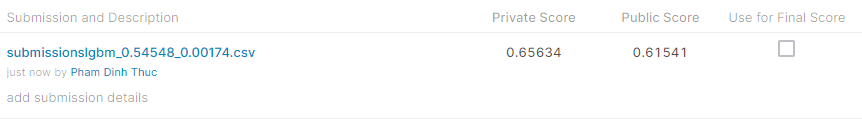

# 3. NHÌN LẠI QUÁ TRÌNH LÀM ĐỒ ÁN



Sau bao ngày vất vả làm đồ án thì bây giờ đã kết thúc. Bây giờ là lúc để ngồi uống coffee và tĩnh tâm nhìn lại quá trình làm. Mỗi thành viên sẽ gặp những thuận lợi, khó khăn và từ đó rút ra được những bài học cho riểng mình.



## 3.1 Lê Hữu Phúc
- Với việc lựa chọn đề tài phù hợp với nền tảng kiến thức nên em có một số thuận lợi trong việc làm đồ án này như: solution có code sẵn, tác giả trình bày rỏ ràng ý tưởng của giải pháp.
- Những khó khăn gặp phải như: Một số ý tác giả chưa giải thích rỏ như phần 2.3.1, 2.3.3, lightGBM, các phương pháp tiền sử lý cho dữ liệu time-series nên cần tìm hiểu nhiều kiến thức mới. Lần đầu tiên tiếp cận kaggle và bài toán thực tế.
- Qua quá trình làm đồ án, em củng tích luỹ những kiến thức bổ ích cho bản thân về triển khai mô hình thực tế cho dữ liệu time-series và quá trình xử lý dữ liệu.



## 3.2. Nguyễn Viết Dũng
 - Trong quá trình thực hiện đồ án, kiến thức từ những môn học trước đều được vận dụng như 1 phương pháp hỗ trợ tìm kiếm giải pháp và hướng đi cho em.
 - Việc làm nhóm giúp em cải thiện khả năng sử dụng github ( trước đây phần lớn môn học đều là bài tập cá nhân và ít sử dụng công cụ colab cũng như git).
 - Tác giả đặt vấn đề xử lý dữ liệu như vấn đề lớn giúp em hiểu được tầm quan trọng của dữ liệu để giải quyết bài toán.
 - Tìm hiểu được 1 vài kiến thức mới trong quá trình nghiên cứu.



## 3.3 Đặng Minh Thọ

- Những khó khăn mà em gặp phải như: chưa triển khai hết những ý tưởng đã đề ra, một số ý tác giả chưa giải thích rõ như phần 2.3.2, 2.3.3 làm khó khăn cho việc hiểu rõ hơn về các giải quyết đó của tác giả
- Qua quá trình làm đồ án, em cũng tích luỹ những kiến thức bổ ích cho bản thân như: về triển khai mô hình học máy trong thực tế cho dữ liệu time-series, áp dụng mô hình LightGBM cho một bài toán thực tế.



## 3.4. Phạm Đình Thục
- Trong đồ án này, với việc lựa chọn được đề tài, solution phù hợp với mình, em đã có một số thuận lợi trong việc làm đồ án này như: solution có code sẵn, được tác giả trình bày rõ ràng giúp cho việc đọc hiểu đề tài dễ dàng hơn.
- Bên cạnh thuận lợi, em cũng gặp một số khó khăn như: solution tác giả giới thiệu còn khá mới đối với em như lightGBM, nên khó có thể hiểu rõ và sâu được nó, một số phần tác giả chưa giải thích rõ ràng như: 2.3.1, 2.3.3, 2.3.4. 
- Qua quá trình làm đồ án này, em rút ra được một số kiến thức hữu ích cho bản thân như: về việc triển khai bài toán time-series trong thực tế, quá trình khám phá, xử lý dữ liệu cho mô hình LightGBM. 



## 3.5 Cải tiến bài toán
Ngoài ra, nếu có thời gian thêm, Nhóm hy vọng có thể cải tiến bài toán này bằng cách:
- Cải tiến về data:
  - Trong mục 2.2.3 Trích chọn dữ liệu thời tiết, ta thu thập thông tin về nhiệt độ trung bình trên toàn bộ dữ liệu. Nếu có thời gian nhóm sẽ nghiên cứu thu thập dữ liệu theo từng vùng cụ thể để nhằm tăng độ chính xác cho thông tin thời tiết tại một khu vực cụ thể.
- Cải tiến ở bước tiền xử lý:
 - Xử lý vấn đề về Outliers ở mục 2.3.1. Tìm ra hệ số **Z** tối ưu nhất cho việc xử lý outliers từ đó giúp tăng độ chính xác mô hình.
- Cải tiến về mô hình:
 - Nếu có thời gian nhóm sẽ nghiên cứu thử nghiệm các kết quả trên các mô hình khác như: XGBoost, ...


# 4. TÀI LIỆU THAM KHẢO

Để hoàn thành đồ án này, nhóm mình đã tham khảo những tài liệu sau:
1. https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting
2. https://github.com/MaxHalford/kaggle-recruit-restaurant
3. https://www.statisticshowto.com/probability-and-statistics/z-score/
4. https://www.mathsisfun.com/data/confidence-interval-calculator.html
5. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
6. https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
7.  https://lightgbm.readthedocs.io/en/latest/
8. https://miai.vn/2021/01/18/k-fold-cross-validation-tuyet-chieu-train-khi-it-du-lieu/
9. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
10. https://gdcoder.com/when-why-to-use-log-transformation-in-regression/

Và nhóm xin gửi lời cảm ơn đặc biệt đến https://stackoverflow.com/ vì đã hỗ trợ nhóm trong quá trình làm đồ án này. :">